# Авторы: Харитонов Денис Александрович, Дянкин Максим Андреевич

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from scipy import stats
from scipy.stats import beta, norm
from scipy.stats import t as t_distribution
from scipy.special import beta as beta_function
from scipy.special import gamma as gamma_function
np.random.seed(42)

# Pricing of exotic options under Black-Scholes

# 1. Forward-Starting Call Option and Monte Carlo Pricing  

## Forward-Starting Call Option
A forward-starting call option is a type of exotic option where the strike price is determined at a future date instead of being fixed at inception. These options are often used in employee stock option plans or as part of structured financial products.  

### Key Features:  
- The option starts at time $0$, but its strike price $K$ is set at time $T_1$.  
- The strike price is typically a fraction of the underlying stock price at $T_1$, such as:  

  $$
  K = S_{T_1} \times m,
  $$  

  where $m$ is a predetermined proportion (e.g., $m = 1$ means an at-the-money option).  
- The option expires at $T_2 > T_1$ and can only be exercised at expiration (European-style).  
- The payoff at expiration is:  

  $$
  \textit{Payoff} = \max(S_{T_2} - m S_{T_1}, 0).
  $$  

## Monte Carlo Pricing of a Forward-Starting Call Option  
Since the strike price is determined at $T_1$, we cannot directly use the standard Black-Scholes formula. Instead, we use Monte Carlo simulation to estimate its price.

### Step 1: Simulate Stock Prices  
Under the Black-Scholes model, the stock price follows the stochastic process:  

$$
dS_t = r S_t dt + \sigma S_t dW_t,
$$  

where:  
- $S_t$ is the stock price at time $t$.  
- $r$ is the risk-free interest rate.  
- $\sigma$ is the volatility of the stock.  
- $W_t$ is a Wiener process (standard Brownian motion).  

Using the closed-form solution for geometric Brownian motion, we simulate the stock prices at both $t_0$ and $T$:  

$$
S_{T_1} = S_0 e^{(r - \frac{1}{2} \sigma^2) T_1 + \sigma \sqrt{T_1} Z_1}
$$  

$$
S_{T_2} = S_{T_1} e^{(r - \frac{1}{2} \sigma^2) ({T_2} - T_1) + \sigma \sqrt{{T_2} - T_1} Z_2}
$$  

where $Z_1, Z_2 \sim N(0,1)$ are independent standard normal variables.

### Step 2: Compute the Option Payoff  
For each simulated path, compute the forward-starting call option payoff:  

$$
\max(S_{T_2} - m S_{T_1}, 0).
$$  

### Step 3: Discount to Present Value  
The price of the option is given by the expected discounted payoff:  

$$
C = e^{-rT_2} \mathbb{E}[\max(S_{T_2} - m S_{T_1}, 0)].
$$  

Using Monte Carlo, we approximate this as:  

$$
C \approx e^{-rT_2} \frac{1}{N} \sum_{i=1}^{N} \max(S_{T_2}^{(i)} - m S_{T_1}^{(i)}, 0),
$$  

where $S_{T_1}^{(i)}$ and $S_{T_2}^{(i)}$ are simulated stock prices for different paths.

On the plot below one can see that resulted price is quite unstable. The main reson is variance of our approximation. General method to resolve an issue is just to increase the number of samples. Are there any other solutions?

### Step 4: Reducing the variance
One can notice that the formula can be rewriten in a different manner using the tower property of a conditional expectation:
$$
  C = \mathbb{E}[e^{-rT_2} \max(S_{T_2} - m S_{T_1}, 0)] =
  \mathbb{E}[e^{-rT_1} \mathbb{E}[e^{-r (T_2 - T_1)}\max(S_{T_2} - m S_{T_1}, 0)|\mathcal{F}_{T_1}]] =
$$

$$
  \mathbb{E}[e^{-rT_1} \textit{Call}\left( S_{T_1}, m S_{T_1}, T_2-T_1, r, \sigma \right)]
$$
Here only value $S_{T_1}$ is used, so we have to sample just one r.v. per estimate instead of two in the previous approach. Practically it significantly reduces the variance.

**Your Task:**  
Implement reduced variance algo

In [ ]:
Normal_pdf = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * Normal_pdf(d1) - K * np.exp(-r*T)* Normal_pdf(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*Normal_pdf(-d2) - S*Normal_pdf(-d1)

def Forward_starting_call_sampling(S, T1, T2, r, sigma, N, q):
    if T2 <= T1:
        print(f'T1 >= T2 with values T1 = {T1} and T2 = {T2}')
    Z1 = np.random.normal(size = N)
    Z2 = np.random.normal(size = N)
    S_T1 = S * np.exp((r - sigma ** 2 / 2) * T1 + sigma * np.sqrt(T1) * Z1)
    S_T2 = S_T1 * np.exp((r - sigma ** 2 / 2) * (T2-T1) + sigma * np.sqrt((T2-T1)) * Z2)
    Call = np.max([S_T2 - S_T1, np.zeros(N)], axis=0)
    return Call.mean() * np.exp(- r * T2), Call.std() * np.exp(-r * T2) * t_distribution.ppf(q, N-1) / np.sqrt(N)

def Forward_starting_call_sampling_reduced_variance(S, T1, T2, r, sigma, N, q):
    if T2 <= T1:
        print(f'T1 >= T2 with values T1 = {T1} and T2 = {T2}')
    Z1 = np.random.normal(size = N)
    Z2 = np.random.normal(size = N)
    S_T1 = S * np.exp((r - sigma**2 / 2) * T1 + sigma * np.sqrt(T1) * Z1)  #TODO
    call_price = np.exp(-r * T1) * BS_CALL(S_T1, S_T1*1, T2-T1, r, sigma)  #TODO
    return call_price.mean(), call_price.std() * t_distribution.ppf(q, N-1) / np.sqrt(N)


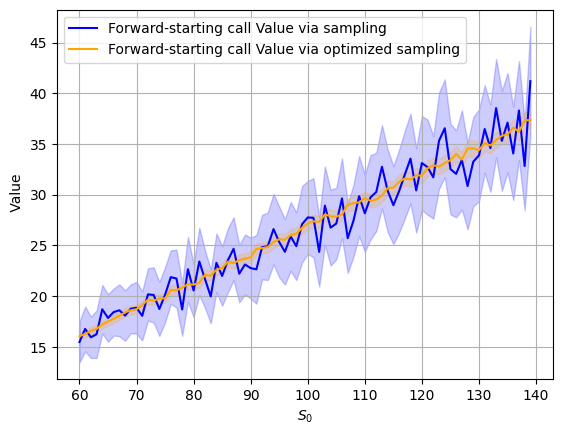

In [ ]:
r = 0.05
T = 1
sigma = 0.3
N = 1_000
q = 0.99
S = np.arange(60,140,1)
T1 = 1
T2 = 4
calls_sampling = np.array([Forward_starting_call_sampling(s, T1, T2, r, sigma, N, q) for s in S])
calls_sampling_reduced_variance = np.array([Forward_starting_call_sampling_reduced_variance(s, T1, T2, r, sigma, N, q) for s in S])
plt.plot(S, calls_sampling[:,0], label='Forward-starting call Value via sampling', color = 'blue')
plt.fill_between(S, calls_sampling[:,0] + calls_sampling[:,1], calls_sampling[:,0] - calls_sampling[:,1], alpha=0.2, color = 'blue')
plt.plot(S, calls_sampling_reduced_variance[:,0], label='Forward-starting call Value via optimized sampling', color = 'orange')
plt.fill_between(S, calls_sampling_reduced_variance[:,0] + calls_sampling_reduced_variance[:,1], calls_sampling_reduced_variance[:,0] - calls_sampling_reduced_variance[:,1], alpha=0.2, color = 'orange')
plt.xlabel('$S_0$')
plt.ylabel(' Value')
plt.grid(True)
plt.legend();

# 2. Binary Option: Definition, Analytical Pricing, and Monte Carlo Simulation

## Binary Option

A **binary option** (also known as a digital option) is an option that pays a fixed amount if a certain condition is met at expiration and $0$ otherwise. For example, a binary (cash-or-nothing) call option pays a fixed cash amount (say, $1$) if the underlying asset price $S_T$ exceeds the strike price $K$ at expiration; otherwise, it pays $0$. Its payoff at time $T$ can be written as:

$$
\text{Payoff} = \mathbf{1}_{\{S_T > K\}},
$$

where $\mathbf{1}_{\{S_T > K\}}$ is the indicator function that is $1$ if $S_T > K$ and $0$ otherwise.

## Analytical Pricing of a Binary Option

Under the Black-Scholes framework, the asset price is assumed to follow a log-normal distribution. The analytical price of a cash-or-nothing binary call option is given by the discounted risk-neutral probability that the option finishes in-the-money. That is:

$$
\text{Price} = e^{-rT} \, \mathbb{P}(S_T > K).
$$

In the Black-Scholes model, the risk-neutral probability can be computed using the standard normal cumulative distribution function. Define:

$$
d_2 = \frac{\ln\left(\frac{S_0}{K}\right) + \left(r - \frac{\sigma^2}{2}\right)T}{\sigma \sqrt{T}},
$$

where:
- $S_0$ is the current asset price,
- $K$ is the strike price,
- $r$ is the risk-free interest rate,
- $\sigma$ is the volatility, and
- $T$ is the time to maturity.

Then the binary call option price becomes:

$$
\text{Price} = e^{-rT}\, \Phi(d_2),
$$

with $\Phi(d_2)$ being the cumulative distribution function of the standard normal distribution.

## Monte Carlo Simulation Pricing

### Step 1. Simulate the Asset Price

Using the risk-neutral dynamics under the Black-Scholes model, the asset price at time $T$ is given by:

$$
S_T = S_0 \, e^{\left(r-\frac{1}{2}\sigma^2\right)T + \sigma \sqrt{T}\, Z},
$$

where $Z \sim N(0,1)$ is a standard normal random variable.

### Step 2. Compute the Payoff

For each simulated asset price, compute the binary option payoff:

$$
\text{Payoff} = \mathbf{1}_{\{S_T > K\}}.
$$

### Step 3. Discount and Average

The Monte Carlo estimate of the option price is the discounted average of the simulated payoffs:

$$
\text{Price} \approx e^{-rT}\,\frac{1}{N}\sum_{i=1}^{N}\mathbf{1}_{\{S_T^{(i)} > K\}},
$$

where $N$ is the number of simulated paths and $S_T^{(i)}$ is the simulated terminal asset price in the $i$th simulation.

**Your Task:**  
Implement black-scholes formula in order to check both solutions


In [ ]:
def monte_carlo_binary_call(S0, K, T, r, sigma, N, q):
    # Simulate terminal asset prices under the risk-neutral measure
    Z = np.random.normal(0, 1, N)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    # Compute binary payoffs: 1 if ST > K, else 0
    payoffs = (ST > K).astype(float)

    return np.exp(-r * T) * np.mean(payoffs), np.exp(-r * T) * payoffs.std() * t_distribution.ppf(q, N-1) / np.sqrt(N)

def black_scholes_digital_call(S0, K, T, r, sigma):
    d2 = (np.log(S0 / K) + (r - sigma**2 / 2) * T) / (sigma * np.sqrt(T)) #TODO
    price = np.exp(-r * T) * norm.cdf(d2) #TODO
    return price

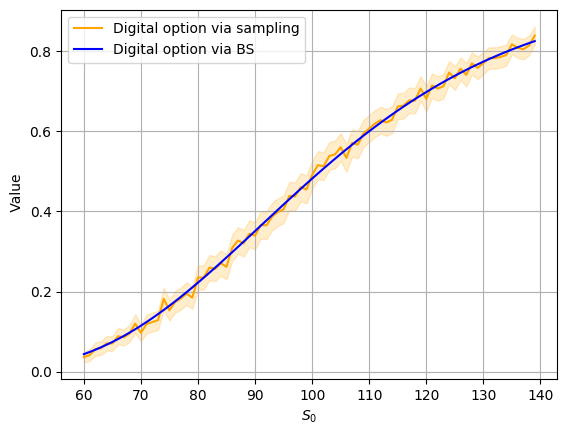

In [ ]:
r = 0.05
K = 100
T = 1
sigma = 0.3
N = 1_000
q = 0.99
S = np.arange(60,140,1)
digital_calls_sampling = np.array([monte_carlo_binary_call(s, K, T, r, sigma, N, q) for s in S])
digital_calls_bs = np.array([black_scholes_digital_call(s, K, T, r, sigma) for s in S])
plt.plot(S, digital_calls_sampling[:,0], label='Digital option via sampling', color = 'orange')
plt.fill_between(S, digital_calls_sampling[:,0] + digital_calls_sampling[:,1], digital_calls_sampling[:,0] - digital_calls_sampling[:,1], alpha=0.2, color = 'orange')
plt.plot(S, digital_calls_bs, label='Digital option via BS', color = 'blue')
plt.xlabel('$S_0$')
plt.ylabel(' Value')
plt.grid(True)
plt.legend();

# 3. Up-and-Out Call Barrier Option

An **up‑and‑out call barrier option** is an exotic option that behaves like a standard European call option, but it becomes worthless (is "knocked out") if the underlying asset price reaches or exceeds a specified barrier level $B$ at any time during the option’s life.

## Option Payoff

At expiration $T$, the payoff of an up‑and‑out call option is:
$$
\text{Payoff} = \mathbf{1}_{\{M_T < B\}} \, \max(S_T - K, 0),
$$
where:
- $S_T$ is the asset price at maturity,
- $K$ is the strike price,
- $M_T = \max_{0\le t \le T} S_t$ is the maximum asset price over the life of the option, and
- $\mathbf{1}_{\{M_T < B\}}$ is an indicator that equals $1$ if the maximum price stays below $B$ (i.e. the barrier is never hit) and $0$ otherwise.

## Pricing via Naive Monte Carlo under the Black‑Scholes Model

### Step 1: Simulating the Asset Path

Under the Black‑Scholes model, the asset price dynamics are given by:
$$
S_t = S_0 \, \exp\Bigl(\bigl(r - \frac{1}{2}\sigma^2\bigr)t + \sigma \sqrt{t}\, Z\Bigr),
$$
where:
- $S_0$ is the current asset price,
- $r$ is the risk‑free interest rate,
- $\sigma$ is the volatility, and
- $Z \sim N(0,1)$ is a standard normal random variable.

For a naive Monte Carlo simulation:
1. Discretize the time interval $[0, T]$ into $M$ steps, each of length $\Delta t = \frac{T}{M}$.
2. For each path, simulate the asset price at each time step.
3. Compute the maximum observed price along the path:
   $$
   M_T^{(i)} = \max\{S_0, S_{\Delta t}^{(i)}, S_{2\Delta t}^{(i)}, \dots, S_T^{(i)}\}.
   $$
4. If $M_T^{(i)} < B$, compute the payoff $\max(S_T^{(i)} - K, 0)$; otherwise, set the payoff to $0$.

### Step 2: Discounting the Expected Payoff

The fair price of the option is estimated by taking the average of the discounted payoffs:
$$
\text{Price} \approx e^{-rT}\,\frac{1}{N}\sum_{i=1}^{N} \mathbf{1}_{\{M_T^{(i)} < B\}}\, \max(S_T^{(i)} - K, 0),
$$
where $N$ is the number of simulated paths.

## Pricing via Monte Carlo with Sampling of the Maximum

The naive approach may underestimate the chance of a barrier crossing because the asset path is simulated only at discrete times. A more accurate method is to incorporate the **Brownian Bridge correction** to sample the maximum between discrete points.

### Brownian Bridge Correction

When you simulate two consecutive asset prices $S_{t_i}$ and $S_{t_{i+1}}$, the path in between can be approximated as a Brownian Bridge. In the log-price space (i.e. $X_t = \ln(S_t)$), the maximum over the interval $(t_i, t_{i+1})$ can be characterized using the conditional distribution:
$$
\mathbb{P}\Bigl(\max_{t_i \le t \le t_{i+1}} X_t \ge m \, \Big| \, X_{t_i}, X_{t_{i+1}} \Bigr)
= \exp\left(-\frac{2\bigl(m - X_{t_i}\bigr)\bigl(m - X_{t_{i+1}}\bigr)}{t_{i+1}-t_i}\right),
$$
for $m$ exceeding both $X_{t_i}$ and $X_{t_{i+1}}$.

By using this probability, you can adjust your simulation as follows:
1. Sample a uniform random variable $U \sim U(0,1)$.
2. Then use an inverse transform technique from the seminar to generate the sample of a maximum of brownian bridge between two **log-prices**.
3. Transform the abovementioned max of log-price to max of price.

This correction reduces discretization bias and leads to a more accurate estimation of the option price.

**Your Task:**  
Implement both simple Monte-Carlo and brownian bridge correction


In [ ]:
def naive_monte_carlo_up_and_out_call(S0, K, B, T, r, sigma, N, M, q):
    dt = T / M
    payoffs = np.zeros(N)
    S = np.zeros(shape=N)
    S[:] = S0
    max_S = S
    for _ in range(M):
        # Simulate next asset price step
        """
        ------------------------Your code here--------------------------
        """
        S *= np.exp((r - sigma**2 / 2) * dt + sigma * np.sqrt(dt) * np.random.normal(size=N))
        max_S = np.maximum(max_S, S)
    # Compute payoff if barrier is not hit
    payoff = np.where(max_S < B, 1, 0) * np.maximum(S - K, 0) #TODO
    price = np.exp(-r * T) * payoff.mean(), np.exp(-r * T) * payoff.std() * t_distribution.ppf(q, N-1) / np.sqrt(N)
    return price

def sample_brownian_bridge_max(X0, X1, dt, b, N):
    """
    Given two log-price values X0 and X1 over a time interval dt,
    returns sample of max of brownian bridge between them.
    """
    # The probability that the maximum exceeds barrier_log is:
    U = np.random.uniform(size=N)
    M = (X0 + X1 + np.sqrt((X0 - X1)**2 - 2 * dt * np.log(U))) / 2 #TODO -/+ sqrt
    return M

def naive_monte_carlo_up_and_out_call_with_bridge(S0, K, B, T, r, sigma, N, M, q):
    dt = T / M
    barrier_log = np.log(B)
    X = np.zeros(shape=N)
    X_next = np.zeros(shape=N)
    X[:] = np.log(S0)
    max_not_hit = (X < barrier_log)
    #max_X = X
    for _ in range(M):
        # Simulate next asset price step
        X_next = X + (r - sigma**2 / 2) * dt + sigma * np.sqrt(dt) * np.random.normal(size=N)
        """
        ------------------------Your code here--------------------------
        """

        # Sample the maximum
        bb_max = sigma * sample_brownian_bridge_max(X / sigma, X_next / sigma, dt, _, N)
        max_not_hit = max_not_hit * (bb_max < barrier_log)
        #max_X = np.maximum(max_X, bb_max)
        """
        ------------------------Your code here--------------------------
        """
        X = X_next
    # Compute payoff if barrier is not hit
    payoff = np.maximum(np.exp(X) - K, 0) * max_not_hit #np.where(max_X < barrier_log, 1, 0)  #TODO
    #print(max_not_hit)
    price = np.exp(-r * T) * payoff.mean(), np.exp(-r * T) * payoff.std() * t_distribution.ppf(q, N-1) / np.sqrt(N)
    return price

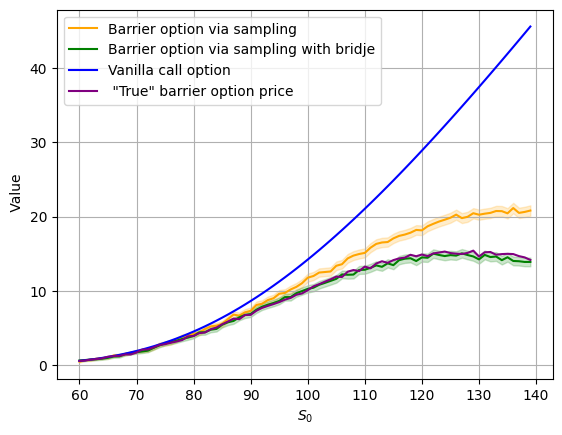

In [ ]:
r = 0.05
K = 100
B = 180
T = 1
sigma = 0.3
N = 10_000
M = 3
q = 0.001
S = np.arange(60,140,1)
up_and_out_call_sampling = np.array([naive_monte_carlo_up_and_out_call(s, K, B, T, r, sigma, N, M, q) for s in S])
up_and_out_call_sampling_with_bridge = np.array([naive_monte_carlo_up_and_out_call_with_bridge(s, K, B, T, r, sigma, N, M, q) for s in S])
TRUE_barrier_call_prices = np.array([naive_monte_carlo_up_and_out_call(s, K, B, T, r, sigma, 10_000, 1000, q) for s in S])
call_bs = np.array([BS_CALL(s, K, T, r, sigma) for s in S])

plt.plot(S, up_and_out_call_sampling[:,0], label='Barrier option via sampling', color = 'orange')
plt.fill_between(S, up_and_out_call_sampling[:,0] + up_and_out_call_sampling[:,1], up_and_out_call_sampling[:,0] - up_and_out_call_sampling[:,1], alpha=0.2, color = 'orange')
plt.plot(S, up_and_out_call_sampling_with_bridge[:,0], label='Barrier option via sampling with bridje', color = 'green')
plt.fill_between(S, up_and_out_call_sampling_with_bridge[:,0] + up_and_out_call_sampling_with_bridge[:,1], up_and_out_call_sampling_with_bridge[:,0] - up_and_out_call_sampling_with_bridge[:,1], alpha=0.2, color = 'green')
plt.plot(S, call_bs, label='Vanilla call option', color = 'blue')
plt.plot(S, TRUE_barrier_call_prices[:,0], label=' "True" barrier option price', color = 'purple')
plt.xlabel('$S_0$')
plt.ylabel(' Value')
plt.grid(True)
plt.legend();

# 4. Asian Options: Definition and Monte Carlo Simulation

## What is an Asian Option?

An **Asian option** is a type of option whose payoff depends on the average price of the underlying asset over a specified time period rather than its price at a single point in time (such as at maturity). This averaging feature helps reduce the option's volatility and the impact of market manipulation or extreme price moves.

**Arithmetic Asian Option:** The payoff is based on the arithmetic average of the asset prices.

For an arithmetic Asian call option, the payoff at maturity $T$ is given by:
$$
\text{Payoff} = \max\Bigl(A_T - K, 0\Bigr),
$$
where:
- $K$ is the strike price,
- $A_T = \frac{1}{M}\sum_{i=1}^{M} S_{t_i}$ is the arithmetic average of the asset prices observed at times $t_1, t_2, \dots, t_M$.

## Monte Carlo Simulation for an Arithmetic Asian Option

### Naive Monte Carlo Approach

1. **Simulate Asset Paths:**  
   Under the Black-Scholes model, the asset price follows:
   $$
   S_t = S_0 \, \exp\Bigl(\left(r - \frac{1}{2}\sigma^2\right)t + \sigma \sqrt{t}\, Z\Bigr),
   $$
   where:
   - $S_0$ is the current asset price,
   - $r$ is the risk-free interest rate,
   - $\sigma$ is the volatility,
   - $Z \sim N(0,1)$ is a standard normal random variable.

2. **Compute the Average Price:**  
   For each simulated path, compute the arithmetic average:
   $$
   A_T = \frac{1}{M}\sum_{i=1}^{M} S_{t_i}.
   $$

3. **Determine the Payoff:**  
   For a call option, the payoff is:
   $$
   \max(A_T - K, 0).
   $$

4. **Discount the Average Payoff:**  
   The option price is given by:
   $$
   \text{Price} \approx e^{-rT} \, \frac{1}{N}\sum_{j=1}^{N} \max\Bigl(A_T^{(j)} - K, 0\Bigr),
   $$
   where $N$ is the number of simulated paths.

Later in the course you'll see how to reduce varince for such a contract.

**Your Task:**  
Implement Monte-Carlo algo

In [ ]:
def naive_monte_carlo_up_and_out_call(S0, K, Tenors, r, sigma, N, q):
    payoffs = np.zeros(N)
    S = np.zeros(shape=N)
    S_avg = np.zeros(shape=N)
    S = S0
    t_prev = 0
    for t in Tenors:
        # Sample next asset price step
        S *= np.exp((r - sigma**2 / 2) * (t - t_prev) + sigma * np.sqrt(t - t_prev) * np.random.randn(N))
        S_avg += S
        t_prev = t
        """----------------------Your code here--------------------------"""
    A = S_avg / len(Tenors) #TODO
    payoff = np.max([A - K, np.zeros(N)], axis=0)
    return np.exp(-r * Tenors[-1]) * payoff.mean(), np.exp(-r * Tenors[-1]) * payoff.std() * t_distribution.ppf(q, N-1) / np.sqrt(N)

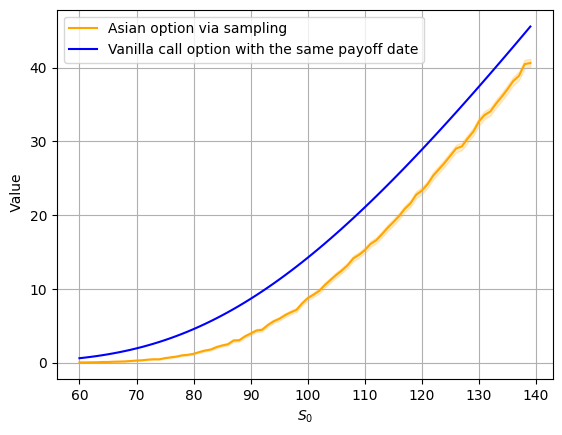

In [ ]:
r = 0.05
K = 100
Tenors = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
sigma = 0.3
N = 10_000
q = 0.99
S = np.arange(60,140,1)
asian_calls_sampling = np.array([naive_monte_carlo_up_and_out_call(s, K, Tenors, r, sigma, N, q) for s in S])
call_bs = np.array([BS_CALL(s, K, Tenors[-1], r, sigma) for s in S])
plt.plot(S, asian_calls_sampling[:,0], label='Asian option via sampling', color = 'orange')
plt.plot(S, call_bs, label='Vanilla call option with the same payoff date', color = 'blue')
plt.fill_between(S, asian_calls_sampling[:,0] + asian_calls_sampling[:,1], asian_calls_sampling[:,0] - asian_calls_sampling[:,1], alpha=0.2, color = 'orange')
plt.xlabel('$S_0$')
plt.ylabel(' Value')
plt.grid(True)
plt.legend()
plt.show()

# 5. Floating-Strike Lookback Put Option

A **floating-strike lookback put option** is an exotic option whose payoff depends on the difference between the maximum asset price observed during the option’s lifetime and the terminal asset price. In other words, the payoff at maturity $T$ is given by:
$$
\text{Payoff} = \Bigl(\max_{0\le t\le T} S_t - S_T\Bigr)_+,
$$
where:
- $S_t$ is the asset price at time $t$,
- $\max_{0\le t\le T} S_t$ is the maximum asset price achieved over the life of the option,
- $S_T$ is the asset price at maturity,
- $(x)_+ = \max(x, 0)$ ensures that the payoff is non-negative.

Because the strike is determined by the maximum price reached, the holder benefits if the asset falls below its previous peak.

## Analytical Pricing under the Black‑Scholes Model

Closed-form solutions exist for floating-strike lookback options. The derivations (see, for example, the work of Goldman, Sosin, and Gatto (1979)) involve the joint distribution of the terminal asset price and its maximum. For the floating-strike lookback put, the analytical price is expressed in terms of the cumulative normal distribution function with adjusted parameters. Although the formulas are quite complex, they typically involve terms that adjust for the correlation between the maximum and the terminal asset price.

Due to the complexity of the closed-form expression, we'll ignore it.

## Monte Carlo Simulation

Because lookback options are path-dependent, Monte Carlo simulation is a natural approach to pricing them. We describe two methods below.

### 1. Naive Monte Carlo Approach

1. **Simulate the Asset Path:**  
   Under the Black‑Scholes model, the asset price follows:
   $$
   S_t = S_0\, \exp\Bigl(\Bigl(r-\frac{1}{2}\sigma^2\Bigr)t + \sigma \sqrt{t}\, Z\Bigr),
   $$
   where:
   - $S_0$ is the initial asset price,
   - $r$ is the risk-free rate,
   - $\sigma$ is the volatility,
   - $Z\sim N(0,1)$ is a standard normal random variable.

2. **Record the Maximum Price:**  
   Discretize the time interval $[0,T]$ into $M$ steps (with $\Delta t = T/M$). For each simulated path, record:
   $$
   M_T = \max\{S_0, S_{\Delta t}, S_{2\Delta t}, \dots, S_T\}.
   $$

3. **Compute the Payoff:**  
   For each path, compute the payoff:
   $$
   \text{Payoff} = \max\Bigl(M_T - S_T,\, 0\Bigr).
   $$

4. **Discount and Average:**  
   The estimated option price is the discounted average of the payoffs:
   $$
   \text{Price} \approx e^{-rT}\,\frac{1}{N}\sum_{i=1}^{N} \max\Bigl(M_T^{(i)} - S_T^{(i)},\, 0\Bigr),
   $$
   where $N$ is the number of simulated paths.

### Brownian bridge correction
As with the barrier option, our scheme incorporates a bias term due to an incorrect approximation of $M_T$. Here the same technique as before again allows us to reduce the bias for free.

**Your Task:**  
Implement both simple MC and BB correction


In [ ]:
def naive_monte_carlo_lookback_put(S0, T, r, sigma, N, M, q):
    dt = T / M
    payoffs = np.zeros(N)
    S = np.zeros(shape=N)
    S[:] = S0
    max_S = S.copy() # добавил .copy()
    for _ in range(M):
        # Simulate next asset price step
        """-----------------------------------Your code here-----------------------------"""
        Z = np.random.normal(0, 1, size = N)
        S = np.multiply(S, np.exp(((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * Z)))
        max_S = np.max([max_S, S], axis = 0)
    # Compute payoff if barrier is not hit
    payoff = np.max([max_S - S, np.zeros(N)], axis = 0) #TODO
    price = np.exp(-r * T) * payoff.mean(), np.exp(-r * T) * payoff.std() * t_distribution.ppf(q, N-1) / np.sqrt(N)
    return price

def sample_brownian_bridge_max(X0, X1, dt, b, N):
    """
    Given two log-price values X0 and X1 over a time interval dt,
    returns sample of max of brownian bridge between them.
    """
    U = np.random.uniform(size=N)
    M = (X0 + X1 + np.sqrt( (X0-X1) ** 2 - 2 * dt * np.log(U))) / 2 #TODO
    return M

def monte_carlo_lookback_put_with_bridge(S0, T, r, sigma, N, M, q):
    dt = T / M
    #barrier_log = np.log(B)
    X = np.zeros(shape=N)
    X_next = np.zeros(shape=N)
    X[:] = np.log(S0)
    #max_not_hit = (X < barrier_log)
    M_max = X.copy()
    for _ in range(M):
        # Simulate next asset price step
        """-----------------------------------Your code here-----------------------------"""
        Z = np.random.normal(0, 1, N)
        X_next = X + (r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * Z

        # Sample the maximum
        """-----------------------------------Your code here-----------------------------"""
        m = sigma * sample_brownian_bridge_max(X/sigma, X_next/sigma, dt, 0, N)
        M_max = np.max([m, M_max], axis = 0)

        X = X_next
    # Compute payoff if barrier is not hit
    payoff = np.max([np.exp(M_max) - np.exp(X), np.zeros(shape = N)], axis = 0)
    price = np.exp(-r * T) * payoff.mean(), np.exp(-r * T) * payoff.std() * t_distribution.ppf(q, N-1) / np.sqrt(N)
    return price

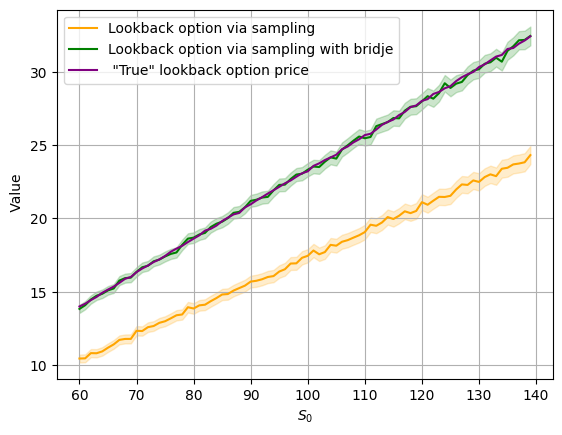

In [ ]:
r = 0.05
T = 1
sigma = 0.3
N = 10_000
M_naive = 10
M_smart = 1
M_check = 100
q = 0.001
S = np.arange(60,140,1)
lookback_put_sampling = np.array([naive_monte_carlo_lookback_put(s, T, r, sigma, N, M_naive, q) for s in S])
lookback_put_sampling_with_bridge = np.array([monte_carlo_lookback_put_with_bridge(s, T, r, sigma, N, M_smart, q) for s in S])
TRUE_lookback_put_prices = np.array([monte_carlo_lookback_put_with_bridge(s, T, r, sigma, 100_000, M_check, q) for s in S])

plt.plot(S, lookback_put_sampling[:,0], label='Lookback option via sampling', color = 'orange')
plt.fill_between(S, lookback_put_sampling[:,0] + lookback_put_sampling[:,1], lookback_put_sampling[:,0] - lookback_put_sampling[:,1], alpha=0.2, color = 'orange')
plt.plot(S, lookback_put_sampling_with_bridge[:,0], label='Lookback option via sampling with bridje', color = 'green')
plt.fill_between(S, lookback_put_sampling_with_bridge[:,0] + lookback_put_sampling_with_bridge[:,1], lookback_put_sampling_with_bridge[:,0] - lookback_put_sampling_with_bridge[:,1], alpha=0.2, color = 'green')
plt.plot(S, TRUE_lookback_put_prices[:,0], label=' "True" lookback option price', color = 'purple')
plt.xlabel('$S_0$')
plt.ylabel(' Value')
plt.grid(True)
plt.legend()

# 6. Exchange Option: Definition, Analytical Pricing, and Monte Carlo Simulation

## What is an Exchange Option?

An **exchange option** gives the holder the right, but not the obligation, to exchange one asset for another at maturity. Typically, if we denote the prices of the two assets at time $T$ by $S_T^1$ and $S_T^2$, the payoff of a call exchange option is:
$$
\text{Payoff} = \max\Bigl(S_T^1 - S_T^2,\, 0\Bigr).
$$
This means that at maturity, the holder can exchange asset 2 for asset 1 if asset 1 is more valuable than asset 2.

## Analytical Pricing using the Margrabe Formula

Under the Black‑Scholes framework, when the two assets follow correlated geometric Brownian motions, the exchange option can be priced analytically using the **Margrabe formula**. Suppose that:
- $S_t^1$ and $S_t^2$ are the prices of the two assets,
- They follow dynamics:
  $$
  dS_t^1 = S_t^1 \left(\mu_1 \, dt + \sigma_1 \, dW_t^1\right),
  $$
  $$
  dS_t^2 = S_t^2 \left(\mu_2 \, dt + \sigma_2 \, dW_t^2\right),
  $$
- The Brownian motions $W_t^1$ and $W_t^2$ have correlation $\rho$.

In the risk-neutral framework, the Margrabe formula gives the price $C$ of the option to exchange asset 2 for asset 1 as:
$$
C = S_0^1 \, \Phi(d_1) - S_0^2 \, \Phi(d_2),
$$
where:
$$
d_1 = \frac{\ln\left(\frac{S_0^1}{S_0^2}\right) + \frac{1}{2}\sigma_M^2T}{\sigma_M\sqrt{T}}, \qquad
d_2 = d_1 - \sigma_M\sqrt{T},
$$
and the combined volatility $\sigma_M$ is given by:
$$
\sigma_M = \sqrt{\sigma_1^2 + \sigma_2^2 - 2\rho\sigma_1\sigma_2}.
$$
Here, $\Phi(\cdot)$ is the cumulative distribution function of the standard normal distribution.

## Monte Carlo Simulation

Since an analytical formula exists, Monte Carlo simulation is often used for more complex variations (or when path-dependency is introduced). The steps to price a plain vanilla exchange option via Monte Carlo under the Black‑Scholes model are:

### 1. Simulate Asset Paths

Simulate the terminal prices $S_T^1$ and $S_T^2$ using the risk-neutral dynamics:
$$
S_T^1 = S_0^1 \exp\Bigl(\left(r - \frac{1}{2}\sigma_1^2\right)T + \sigma_1\sqrt{T}\, Z_1\Bigr),
$$
$$
S_T^2 = S_0^2 \exp\Bigl(\left(r - \frac{1}{2}\sigma_2^2\right)T + \sigma_2\sqrt{T}\, Z_2\Bigr),
$$
where $Z_1$ and $Z_2$ are standard normal random variables with correlation $\rho$ (they can be generated by correlating independent normals).

### 2. Compute the Payoff

For each simulated pair, compute the exchange option payoff:
$$
\text{Payoff} = \max\Bigl(S_T^1 - S_T^2,\, 0\Bigr).
$$

### 3. Discount the Payoff

The Monte Carlo estimate for the option price is the discounted average of the simulated payoffs:
$$
\text{Price} \approx e^{-rT}\,\frac{1}{N}\sum_{i=1}^{N}\max\Bigl(S_T^{1,(i)} - S_T^{2,(i)},\, 0\Bigr),
$$
where $N$ is the number of simulation paths.

**Your Task:**  
Implement Monte-Carlo

In [ ]:
def margrabe_price(S0_1, S0_2, T, sigma1, sigma2, rho):
    sigma_M = np.sqrt(sigma1**2 + sigma2**2 - 2 * rho * sigma1 * sigma2)
    d1 = (np.log(S0_1 / S0_2) + 0.5 * sigma_M**2 * T) / (sigma_M * np.sqrt(T))
    d2 = d1 - sigma_M * np.sqrt(T)
    price = S0_1 * norm.cdf(d1) - S0_2 * norm.cdf(d2)
    return price

def monte_carlo_exchange_option(S0_1, S0_2, T, r, sigma1, sigma2, rho, N, q):
    # Generate correlated standard normal variables
    Z1 = np.random.normal(0, 1, N)
    Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(0, 1, N) #TODO

    # Simulate terminal asset prices under risk-neutral dynamics
    ST1 = S0_1 * np.exp((r - sigma1**2 / 2) * T + sigma1 * np.sqrt(T) * Z1) #TODO
    ST2 = S0_2 * np.exp((r - sigma2**2 / 2) * T + sigma2 * np.sqrt(T) * Z2) #TODO

    # Calculate payoff for each simulation
    payoffs = np.max([ST1 - ST2, np.zeros(N)], axis=0)
    return np.exp(-r * T) * np.mean(payoffs), np.exp(-r * T) * payoffs.std() * t_distribution.ppf(q, N-1) / np.sqrt(N)

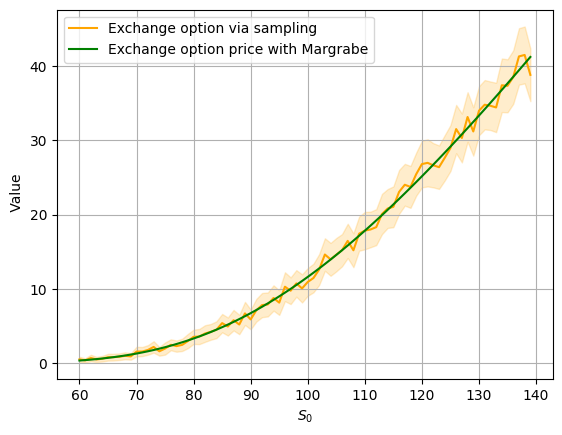

In [ ]:
r = 0.05
T = 1
sigma1 = 0.3
sigma2 = 0.15
rho=.3
N = 1_000
q = 0.001
S0_2 = 100
S = np.arange(60,140,1)
exchange_sampling = np.array([monte_carlo_exchange_option(s, S0_2, T, r, sigma1, sigma2, rho, N, q) for s in S])
exchange_margrabe = np.array([margrabe_price(s, S0_2, T, sigma1, sigma2, rho) for s in S])

plt.plot(S, exchange_sampling[:,0], label='Exchange option via sampling', color = 'orange')
plt.fill_between(S, exchange_sampling[:,0] + exchange_sampling[:,1], exchange_sampling[:,0] - exchange_sampling[:,1], alpha=0.2, color = 'orange')
plt.plot(S, exchange_margrabe, label='Exchange option price with Margrabe', color = 'green')
plt.xlabel('$S_0$')
plt.ylabel(' Value')
plt.grid(True)
plt.legend();

# 7. Derivation of the Feynman–Kac Formula with Time- and State-Dependent Discount Rate and Source Term

**Problem Statement:**

Consider a function $F(t,x)$ that satisfies the following partial differential equation (PDE):

$$
\frac{\partial F}{\partial t}(t,x) + \mu(t,x) \frac{\partial F}{\partial x}(t,x) + \frac{1}{2}\sigma^2(t,x) \frac{\partial^2 F}{\partial x^2}(t,x) - r(t,x) F(t,x) + k(t,x) = 0,
$$

for $t \in [0,T)$ and $x \in \mathbb{R}$, with the terminal condition

$$
F(T,x) = \Phi(x),
$$

where:
- $\mu(t,x)$ and $\sigma(t,x)$ are given functions representing the drift and volatility of an Itô process $X_t$,
- $r(t,x)$ is a discount rate that depends on both time $t$ and state $x$,
- $k(t,x)$ is a given source (or forcing) term,
- $\Phi(x)$ is a known payoff function at time $T$.

**Feynman–Kac formula:**  
   Show that the solution $F(t,x)$ of the above PDE can be written in the form:
   $$
   F(t,x) = \mathbb{E}\!\left[\Phi(X_T)e^{-\int_t^T r(s,X_s)\,ds} + \int_t^T e^{-\int_t^s r(u,X_u)\,du}\,k(s,X_s)\,ds \,\Big|\, X_t=x\right].
   $$

**Your Task:**  
Provide a step-by-step derivation of the formula above as in the classroom.



### Illustration of BS pricing with finite differencing:

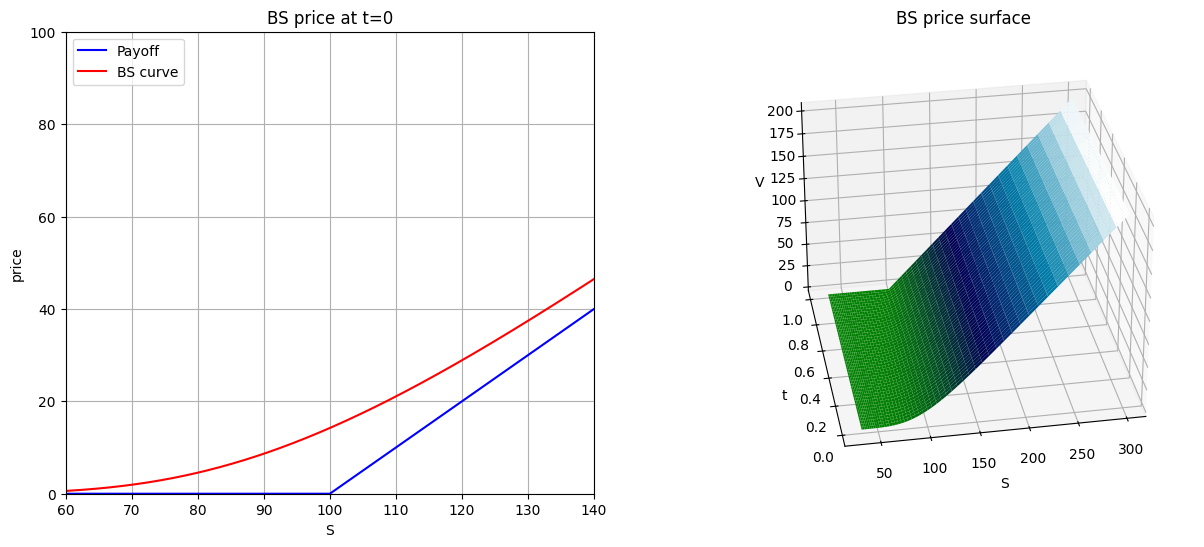

In [ ]:
from scipy import sparse
from scipy.sparse.linalg import splu
from scipy.sparse.linalg import spsolve

from IPython.display import display
from matplotlib import cm

r = 0.05
sig = 0.3
S0 = 100
K = 100
Texpir = 1

Nspace = 3000  # M space steps
Ntime = 2000  # N time steps

S_max = 3 * float(K)
S_min = float(K) / 3
def Call_payoff(S, K):
    return np.maximum(S - K, 0)

def PDE_pricer(S0, K, Texpir, r, sig, Payoff_function, S_min, S_max, Nspace, Ntime):
    X0 = np.log(S0)
    x_max = np.log(S_max)  # A2
    x_min = np.log(S_min)  # A1
    x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)  # space discretization
    T, dt = np.linspace(0, Texpir, Ntime, retstep=True)  # time discretization
    Payoff = Payoff_function(np.exp(x))  # Payoff
    V = np.zeros((Nspace, Ntime))  # grid initialization
    offset = np.zeros(Nspace - 2)  # vector to be used for the boundary terms

    V[:, -1] = Payoff  # terminal conditions
    V[-1, :] = np.exp(x_max) - K * np.exp(-r * T[::-1])  # boundary condition
    V[0, :] = 0  # boundary condition
    # construction of the tri-diagonal matrix D
    sig2 = sig * sig
    dxx = dx * dx

    a = (dt / 2) * ((r - 0.5 * sig2) / dx - sig2 / dxx)
    b = 1 + dt * (sig2 / dxx + r)
    c = -(dt / 2) * ((r - 0.5 * sig2) / dx + sig2 / dxx)

    D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace - 2, Nspace - 2)).tocsc()
    # Backward iteration
    for i in range(Ntime - 2, -1, -1):
        offset[0] = a * V[0, i]
        offset[-1] = c * V[-1, i]
        V[1:-1, i] = spsolve(D, (V[1:-1, i + 1] - offset))

    S = np.exp(x)
    return V, S, Payoff
V, S, Payoff = PDE_pricer(S0, K, Texpir, r, sig, lambda x: Call_payoff(x, K), S_min, S_max, Nspace, Ntime)

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="3d")

ax1.plot(S, Payoff, color="blue", label="Payoff")
ax1.plot(S, V[:, 0], color="red", label="BS curve")
ax1.set_xlim(60, 140)
ax1.set_ylim(0, 100)
ax1.set_xlabel("S")
ax1.set_ylabel("price")
ax1.legend(loc="upper left")
ax1.grid(True)
ax1.set_title("BS price at t=0")

T = np.linspace(0, Texpir, Ntime)
X, Y = np.meshgrid(T, S)
ax2.plot_surface(Y, X, V, cmap=cm.ocean)
ax2.set_title("BS price surface")
ax2.set_xlabel("S")
ax2.set_ylabel("t")
ax2.set_zlabel("V")
ax2.view_init(30, -100)  # this function rotates the 3d plot
plt.show()

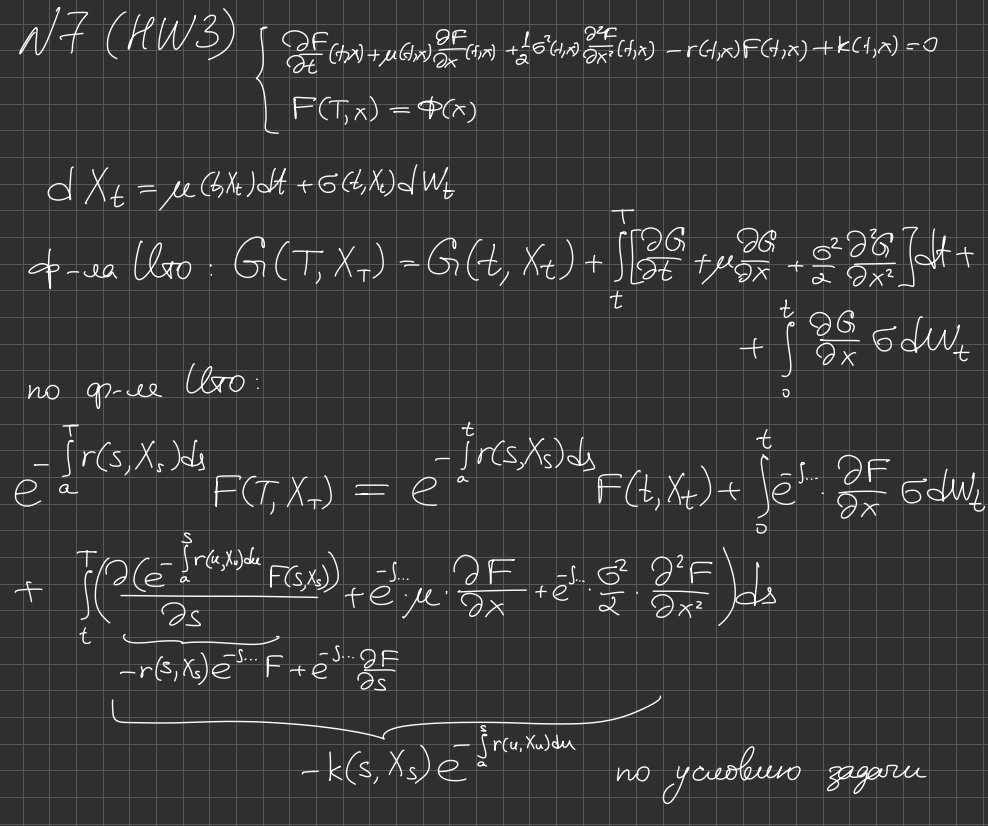

: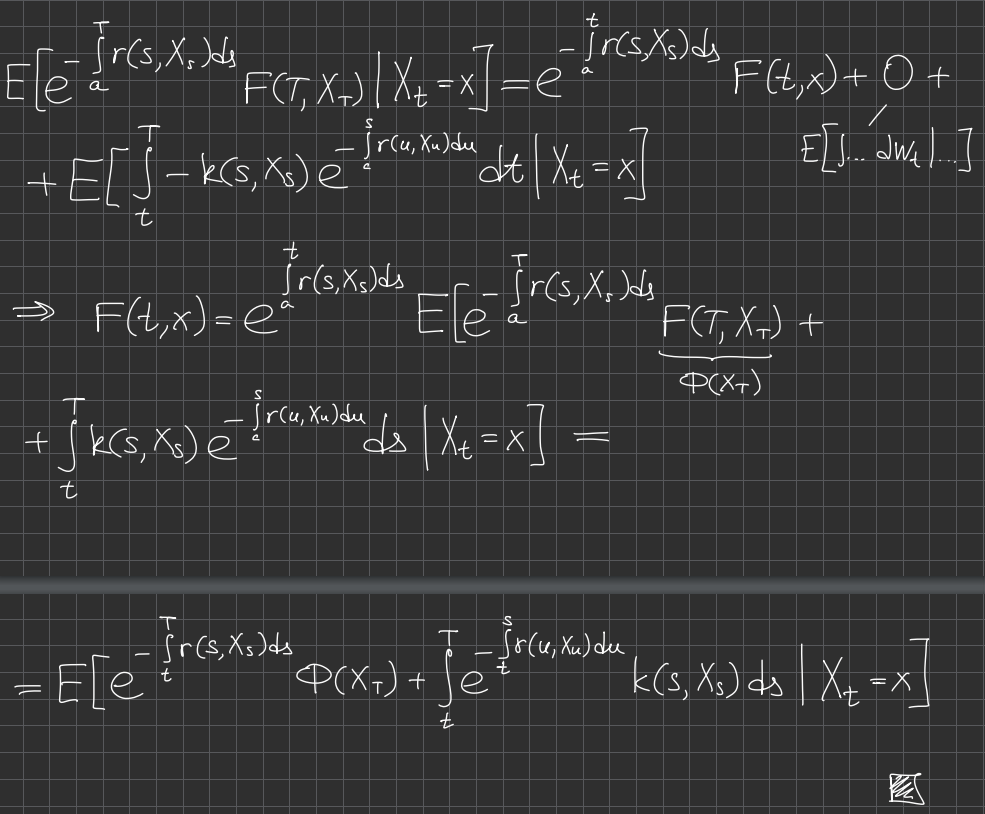